# `rioxarray`

In this lesson we will introduce [`rioxarray`](https://corteva.github.io/rioxarray/stable/), a Python extension for `xarray` to manipulate `xarray.DataArray`s as rasters. 

The name `rioxarray` stands for *raster input/output + xarray*. 

## About the data
The raster files we will use today come from the [US National Agriculture Imagery Program (NAIP)](https://naip-usdaonline.hub.arcgis.com). 
NAIP images are are high-resolution aerial images with four spectral bands: red (R), green (G), blue (B) and near-infrared (NIR). 
The raster's we'll use today are from 2020.

The data used in this lesson was pre-processing from a complete NAIP scene to separate the RGB bands from the NIR band and reduce the spatial extent. 
The data was accessed through [Microsoft's Planetary Computer NAIP data repository](https://planetarycomputer.microsoft.com/dataset/naip#overview).

## Import a TIF file

Let's start by loading the libraries we will use: 

In [10]:
import os

import numpy as np
import matplotlib.pyplot as plt

import geopandas as gpd
from shapely.geometry import Polygon

import rioxarray as rioxr

There are [multiple ways of opening a TIF file using `xarray` or `rioxarray`](https://corteva.github.io/rioxarray/html/getting_started/getting_started.html). 
Using the `rioxarray.open_rasterio()` function to open the TIF file is a simple way to import the raster file as an `xarray.DataArray` and make sure all our geospatial data gets loaded correctly:

In [19]:
# Import NIR TIF file
# Set root path directory
root = os.path.join('/',
                  'courses',
                  'EDS220',
                  'data',
                  'rioxarray_lesson_data')

In [20]:
# Import NIR TIF file
fp = os.path.join(root,'NAIP_SB_nir.tif')
nir = rioxr.open_rasterio(fp)
nir

<xarray.DataArray (band: 1, y: 3208, x: 2419)> Size: 8MB
[7760152 values with dtype=uint8]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 19kB 2.512e+05 2.512e+05 ... 2.527e+05 2.527e+05
  * y            (y) float64 26kB 3.813e+06 3.813e+06 ... 3.811e+06 3.811e+06
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

In [21]:
print('Shape: ', nir.shape)
print('Data type: ', nir.dtype)

Shape:  (1, 3208, 2419)
Data type:  uint8


`uint8` = one of the smallest number data types for Python = unsigned integers with 8 bits. It is used to represent numbers from 0 to 254.

In [22]:
print(type(nir.values))
nir.values

<class 'numpy.ndarray'>


array([[[167, 164, 161, ..., 147, 152, 151],
        [170, 170, 168, ..., 151, 149, 154],
        [176, 177, 177, ..., 151, 151, 151],
        ...,
        [ 94,  88, 101, ...,  83,  88,  79],
        [108,  95, 103, ...,  92,  91,  75],
        [ 94,  90, 104, ...,  87,  88,  82]]], dtype=uint8)

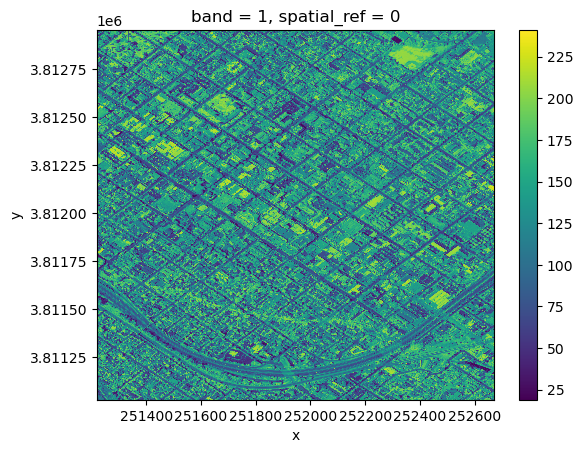

In [23]:
# Plot the raster
nir.plot()

### Drop a dimension

Notice that our raster has an unnecessary extra dimension: band
If you are working with a single band raster, it is redundant to have to call the band (treated as third dimension) so we can drop the dimension to simplify since you would obviously be calling the only band 

In [25]:
# Drop dimension to make the raster 2d, not 3d since it's only 1 dimension deep anyways
print('Size of dimensions: ', dict(nir.sizes))

Size of dimensions:  {'band': 1, 'y': 3208, 'x': 2419}


Let's squeeze the band dimension by:
1. `squeeze()` method, with no parameters it gets rid of all dimension of length 1
2. drop the `coordinates` associated with the dimension using the `drop_vars()` : 

In [26]:
# Original dimensions and coordinates
print(nir.dims, nir.coords)

('band', 'y', 'x') Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 19kB 2.512e+05 2.512e+05 ... 2.527e+05 2.527e+05
  * y            (y) float64 26kB 3.813e+06 3.813e+06 ... 3.811e+06 3.811e+06
    spatial_ref  int64 8B 0


In [27]:
# Remove length 1 dimension (band) and reassign
nir = nir.squeeze()
print(nir.dims, nir.coords)

('y', 'x') Coordinates:
    band         int64 8B 1
  * x            (x) float64 19kB 2.512e+05 2.512e+05 ... 2.527e+05 2.527e+05
  * y            (y) float64 26kB 3.813e+06 3.813e+06 ... 3.811e+06 3.811e+06
    spatial_ref  int64 8B 0


In [ ]:
# Remove coordinates associated to band dimension
nir = nir.drop_vars('band')
print(nir.dims, nir.cords)

In [28]:
## `rio` accessor
print('Number of bands: ', nir.rio.count)
print('Height: ', nir.rio.height)
print('Width: ', nir.rio.width)
print('Spatial bounding box: ')
print(nir.rio.bounds(), '\n')

print('CRS', nir.rio.crs)


Number of bands:  1
Height:  3208
Width:  2419
Spatial bounding box: 
(251218.8, 3811027.2, 252670.19999999998, 3812952.0) 

CRS EPSG:26911


### Working with Multi-band rasters
Now we are going to work with a multi-band raster

In [31]:
# Import RGB raster
fp = os.path.join(root, 'NAIP_SB_rgb.tif')
rgb = rioxr.open_rasterio(fp)
rgb

<xarray.DataArray (band: 3, y: 3208, x: 2419)> Size: 23MB
[23280456 values with dtype=uint8]
Coordinates:
  * band         (band) int64 24B 1 2 3
  * x            (x) float64 19kB 2.512e+05 2.512e+05 ... 2.527e+05 2.527e+05
  * y            (y) float64 26kB 3.813e+06 3.813e+06 ... 3.811e+06 3.811e+06
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

Since this raster has three bands we can plot it as an image using the `.plotimshow()` method which will interpret the three bands of the object as RGB bands.

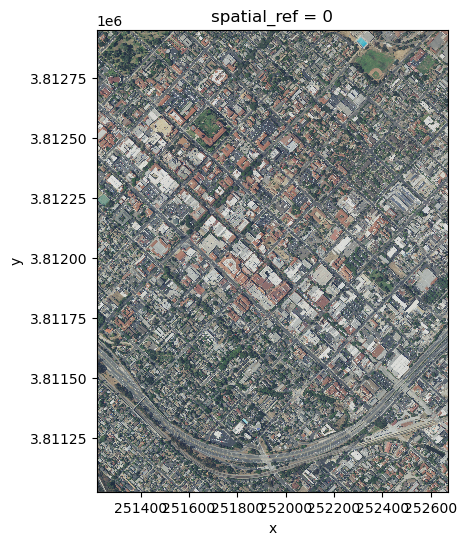

In [32]:
# Plot the 3 bands of the raster

rgb_aspect_ratio = rgb.rio.width / rgb.rio.height # Raster's aspect ratio
rgb.plot.imshow(size = 6, # Plots height in inches
                aspect = rgb_aspect_ratio # Ratio of width/height
               )

## Clip a raster

Our area of interest (AOI) for this lesson is a smaller region including a few blocks around NCEAS. This area is already outlined in a GeoJSON file:


<Axes: >

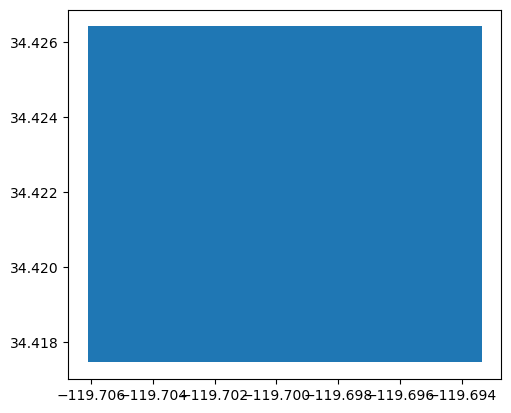

In [42]:
fp = os.path.join(root, 'SB_aoi.geojson')
aoi = gpd.read_file(fp)
aoi.plot()

Remember: we need to match the CRS

In [45]:
# Examine CRSs
print('aoi CRS ', aoi.crs)
print('rgb CRS ', rgb.rio.crs)
print('nir CRS ', nir.rio.crs)

aoi CRS  EPSG:4326
rgb CRS  EPSG:26911
nir CRS  EPSG:26911


In [46]:
# Reproject

aoi = aoi.to_crs(rgb.rio.crs)
assert aoi.crs == rgb.rio.crs

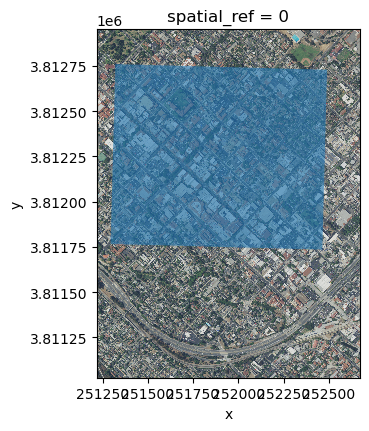

In [49]:
# Plot RGB raster with AOI overlay
fig, ax = plt.subplots(figsize=(6, 6 * rgb_aspect_ratio)) # Directly set size
rgb.plot.imshow(ax=ax)
aoi.plot(ax=ax, alpha=0.6)
plt.show()

To clip the raster we use the `rio.clip_box()` method

In [50]:
# Clip rasters to AOI
# * unpacks the objects(takes array and makes one parameter for each, probably a list)
rgb_small = rgb.rio.clip_box(*aoi.total_bounds)

In [51]:
# Define bounds of layer
aoi.total_bounds

array([ 251294.31339082, 3811734.95697039,  252490.65041356,
       3812760.09703315])

In [52]:
# Clip rasters to AOI
rgb_small = rgb.rio.clip_box(*aoi.total_bounds)
nir_small = nir.rio.clip_box(*aoi.total_bounds)

Original shape:  (3208, 2419)
Clipped shape:  (1710, 1995)


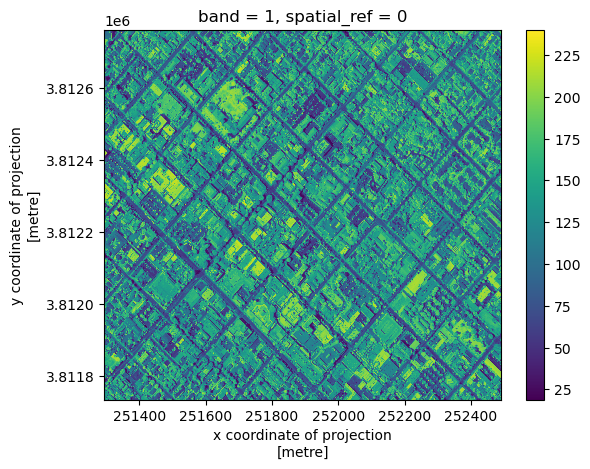

In [53]:
# Examine the clipped data
print('Original shape: ', nir.shape)
print('Clipped shape: ', nir_small.shape)

nir_small.plot()

Original shape:  (3, 3208, 2419)
Clipped shape:  (3, 1710, 1995)


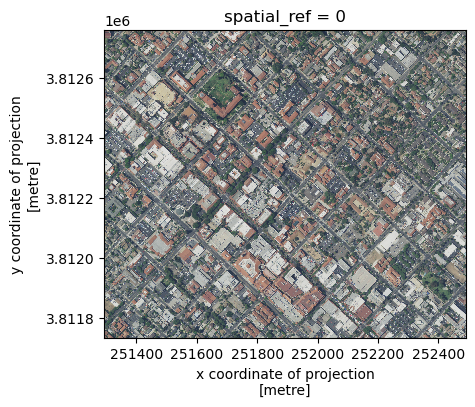

In [54]:
# Examine the clipped data
print('Original shape: ', rgb.shape)
print('Clipped shape: ', rgb_small.shape)

# Plot with the correct size
ratio = rgb_small.rio.width / rgb_small.rio.height
rgb_small.plot.imshow(size = 4,
                      aspect = ratio
                     )


### Raster algebra

In our case we are interested in computing the normalized difference in vegetation index (NDVI)

NDVI is an index commonly used to check if an area has live green vegetation.

- NDVI calculations range -1 to 1
- negative values = water, impervious surface, rocks, snow, clouds
- near 0 = bare soil 0.1 - 0.2
- plants = always positive between 0.2 - 1

Formula for NDVI is:

$ NDVI = \frac{NIR - NIR}{NIR + NIR}$


In [56]:
# Select the red band (by using the dimension name and coordiante by label)
red = rgb_small.sel(band=1) # Select name of band
red

<xarray.DataArray (y: 1710, x: 1995)> Size: 3MB
[3411450 values with dtype=uint8]
Coordinates:
    band         int64 8B 1
  * x            (x) float64 16kB 2.513e+05 2.513e+05 ... 2.525e+05 2.525e+05
  * y            (y) float64 14kB 3.813e+06 3.813e+06 ... 3.812e+06 3.812e+06
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

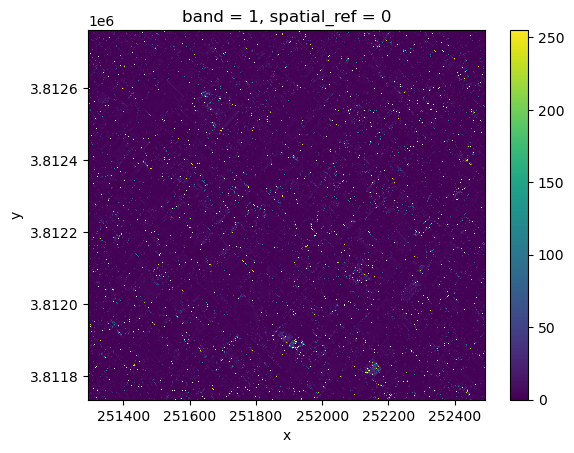

In [58]:
ndvi = (nir - red)/(nir + red)
ndvi.plot()

## Data type issues
The rasters had data type `uint8`, a very small data type holding only integers from 0 to 255.
In particular, when you do calcualtions with `uint8` they don't return what you expect when working with integers

- always check data types
- always check preliminary results

In [60]:
np.uint8(150) + np.uint8(150)

/tmp/ipykernel_2112826/1890984988.py:1: RuntimeWarning: overflow encountered in scalar add
  np.uint8(150) + np.uint8(150)


44

## Updating data types

To be able to perform calculations successfully we will need to update the data type of our rasters into `int16`

In [62]:
# Update data type to int16 to perform NDVI calculation
red16 = red.astype('int16')
nir16 = nir_small.astype('int16')

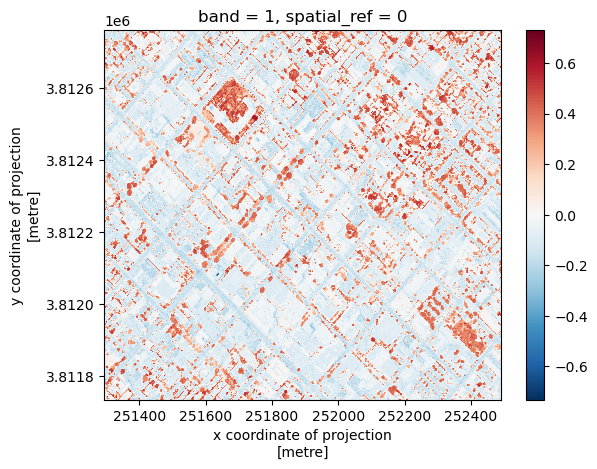

In [63]:
ndvi = (nir16 - red16)/(nir16 + red16)
ndvi.plot()